# Data compression
Not all the data we collect is relevant for the task at hand. We might want to reduce the size of the data to lower the computational cost, reduce overfitting, save storage space and even improve the computation results. We have seen how to eliminate less rilevant features from a data set with little loss of information here we address how to reduce the feature space by looking at linear combinations of the original most relevant features in order to represent our data points in a lower-dimensional subspace. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

numpy version: 1.23.1
pandas version: 1.4.3


## The Wine data set

In [2]:
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine_df.shape

(178, 14)

In [3]:
wine_df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
wine_df.head(3)

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


## Data partition

In [4]:
from sklearn.model_selection import train_test_split

X, y = wine_df.iloc[:, 1:].values, wine_df.iloc[:, 0].values
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Data standardization

In [5]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Principal Component Analysis
The Principal Component Analysis is a technique used to reduce the space dimensionality a the data set. The information in the dataset is where the variance is higher so the basic idea is to find out the direction that contains the largest variance and then another direction, orthogonal to the first one, that contains what has been left from the first direction and so on till we have the amount of information that we want in a lower dimensional space. The steps to achieve this result are

1. Compute the covariance matrix $\Sigma$
2. Compute the eigen vectors and eigen values of the covariance matrix
3. Select the eigen vectors that contain most of the information (largest eigen values)
4. Build a projection matrix $W$ from the selected eigen vectors
5. Project the original data points onto the eigen vectors space so that $X'=XW$

### Covariance matrix
We use the covariance matrix to figure out whether there are features that are not completely independent. If there is any kind of relationships we might use only a subset of the original features instead of the full set of features without any loss of information. If the relationship cannot be decribed as an analytical function we still may use it to reduce the dimesional space but with some loss of information. The element of a covariance matrix is defined as 

$$\sigma_{jk} = \sum_{i=1}^n (x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)$$

where $\mu_J$ and $\mu_k$ are the sample mean of feature j and k respectively.

NumPy provides a function to compute the covariance matrix and we will use it to compute the covariance matrix of the Wine data set and its eigen values and eigen vectors.

In [6]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


The eigen values tell us which combination of feautures holds most of the variance. We can see that the first three eigen vectors contain 67% of the variance that is information.

In [7]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
sum(var_exp[:3])

0.6720155475408881

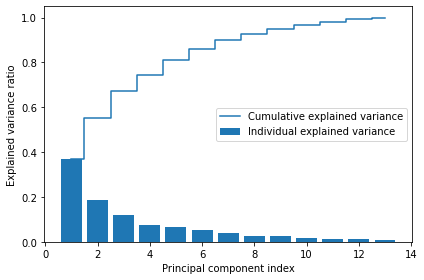

In [8]:
plt.bar(range(1, 14), var_exp, align='center', label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The idea of PCA is to select the most important eigen vectors and map the input data set to the lower dimensional space defined by the selected high rank eigen vectors.  

In [9]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

We select two eigen vectors that define the space onto we want to project the input data. The two eigen vectors will define our projection matrix W from the original 13-dimensional space to the 2-dimensional eigen vectors space.

In [10]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
W.shape

(13, 2)

The projection of the data points from the original space 13-dimensional space onto the 2-dimensional eigen vectors space can be done via matrix multiplication. After the transformation each data point wil have two coordinates in the 2D eigen vectors space.

In [11]:
X_train_pca = X_train_std.dot(W)
X_train_pca.shape

(124, 2)

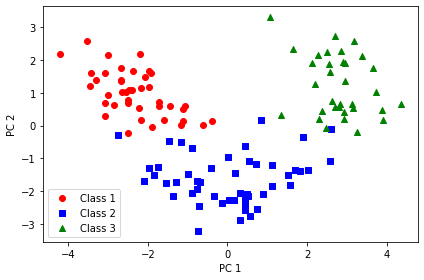

In [12]:
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

The contribution of the original features to each eigen vector are represented by the elements of the W matrix

$$x'_{ij} = \sum_{j=1}^n w_{ij}x_j$$

The coefficients $w_{ij}$ are called *loadings*. We can compute the contributions of the original features to each eigen vector x' as the ratio of the variance of the eigen vector and the sum of the variances of the original features. Since the mean value of the eigen vector.

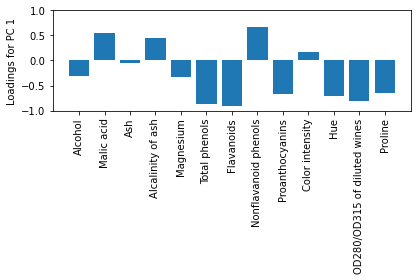

In [13]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(wine_df.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## PCA with Scikit-Learn
Scikit-Learn provides several algorithm for principal components analysis. The [PCA](https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca) module that we use returns the eigen vectors and eigen values and is based on the singular value decomposition ([SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)) algorithm.

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
sum(pca.explained_variance_ratio_)

1.0

We plot the data using only the first two eigen vectors

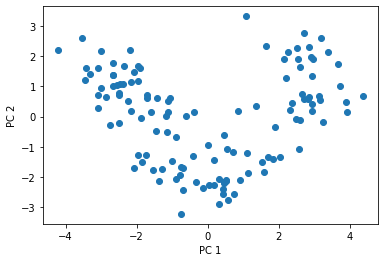

In [15]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Once we have the Wine data in a 2-dimensional space we can classify the data points using one of the algorithms we have seen, such as logistic regression.

In [16]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

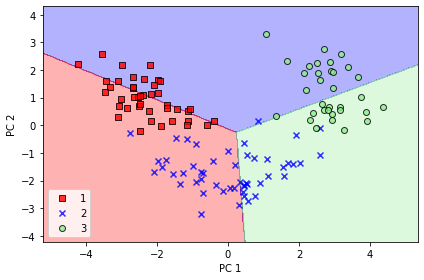

In [43]:
import plot_decision_regions_script
plot_decision_regions_script.plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Linear Discriminant Analysis
Linear discriminant analysis is a classification algorithm that can also be used for dimensionality reduction. One main difference with PCA is that it is a supervised algorithm and the data must include the labels. It is also assumed that the data is normally distributed and the classes have identical covariance matrices. For each class we will have a vector of mean values of size 13. 

We start by computing the mean values of the 13 features available for the three classes of the Wine data set. 

In [18]:
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9065826  -0.34973457  0.32010329 -0.71891449  0.50558678  0.88069702
  0.95894709 -0.55161049  0.54159322  0.23383109  0.58971299  0.65631399
  1.20749382]

MV 2: [-0.87487963 -0.28480003 -0.37347228  0.31571225 -0.38480347 -0.04332505
  0.06345321 -0.09460613  0.07034749 -0.82860474  0.31436962  0.36084258
 -0.72528643]

MV 3: [ 0.199215    0.8660339   0.168163    0.41484489 -0.04511771 -1.02855532
 -1.28756034  0.82867687 -0.77947565  0.96494432 -1.20899133 -1.36215159
 -0.40130076]



We compute the scatter matrix for each class then we compute the *within-class* scatter matrix $S_W$ by adding the three individual scatter matrices together. The scatter matrix is a normalized version of the covariance matrix. 

In [22]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: 'f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


In [23]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


Now we compute the *between-class* scatter matrix $S_B$. We compute the mean of each feature independently of the class

In [26]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # make column vector
mean_overall.shape

(13, 1)

In [28]:
d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: 'f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


We compute the eigen vectors and eigen values of the matrix product $S_W^{-1}S_B$

In [33]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_vals

array([ 0.00000000e+00+0.00000000e+00j,  1.72761522e+02+0.00000000e+00j,
        3.49617809e+02+0.00000000e+00j, -1.80300097e-14+2.66903779e-14j,
       -1.80300097e-14-2.66903779e-14j,  2.61065234e-14+0.00000000e+00j,
       -1.22406096e-14+1.18530267e-14j, -1.22406096e-14-1.18530267e-14j,
        9.05226076e-16+1.68512481e-14j,  9.05226076e-16-1.68512481e-14j,
        7.58495017e-15+0.00000000e+00j, -2.37335353e-15+1.73721395e-15j,
       -2.37335353e-15-1.73721395e-15j])

We sort the pairs of eigen values and corresponding eigen vectors by descending order

In [34]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.76152218979385
3.2209587419662555e-14
3.2209587419662555e-14
2.6106523402387364e-14
1.7038977764581827e-14
1.7038977764581827e-14
1.687554433463065e-14
1.687554433463065e-14
7.584950171788759e-15
2.9412105155181146e-15
2.9412105155181146e-15
0.0


We stack the eigen vectors together to build the W matrix to project the data points from the original features space to the 2D-dimensional subspace of the largest eigenvectors  

In [38]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', W.shape)

Matrix W:
 (13, 2)


The projection is computed by a matrix multiplication: X' = WX. 

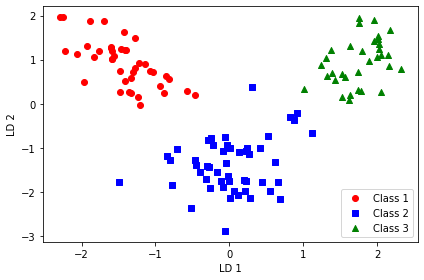

In [47]:
X_train_lda = X_train_std.dot(W)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

We can use the projected data points to determine the boundaries between the three classes using the logistic regression algorithm.

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

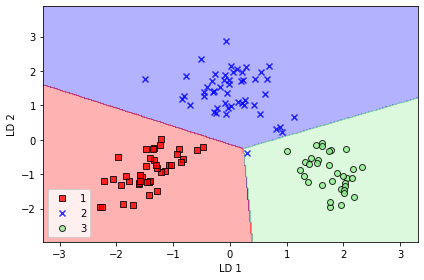

In [46]:
import plot_decision_regions_script as pdr
pdr.plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()